# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [12]:
# Install requirements
!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [13]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [14]:
import sys
print(f'Python version: {sys.version_info}')
print(f'Numpy version: {np.__version__}')
print(f'PyTorch version: {torch.__version__}')

Python version: sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
Numpy version: 1.21.2
PyTorch version: 1.11.0+cu102


In [15]:
# Set seed so that results are reproducible
import random

seed = 43
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [17]:
from torchvision import datasets
from torch.utils.data import DataLoader
batch_size = 32
# Define transforms
transform = transforms.ToTensor()

# Create training set and define training dataloader
training_pre_normalization_data = datasets.MNIST(root='data/raw', train=True, transform=transform, download=True)
training_pre_normalization_loader = DataLoader(training_pre_normalization_data, batch_size=batch_size, shuffle=True)

In [18]:
images = torch.stack([image for image, label in training_pre_normalization_data], dim=3)

# Get the shape of the image
images.shape

torch.Size([1, 28, 28, 60000])

In [19]:
# compute mean and std per channel
mean = images.view(1,-1).mean(dim=1) 
std = images.view(1,-1).std(dim=1)
print(f'Global mean on training dataset is {mean}')
print(f'Global standard deviation on training dataset is {std}')

Global mean on training dataset is tensor([0.1307])
Global standard deviation on training dataset is tensor([0.3081])


In [20]:
validation_split = 0.2

# Define transforms
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.1307, ), (0.3081))])

# Get dataset to split into training and validation set
dataset = datasets.MNIST(root='data/normalized', train=True, transform=transform, download=True)

train_size = int(len(dataset) * (1 - validation_split))
val_size = int(len(dataset) * validation_split)

training_data, validation_data = torch.utils.data.random_split(dataset, [train_size, val_size], 
                                                     generator=torch.Generator().manual_seed(seed))
training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)

# Create test set and define test dataloader
testing_data = datasets.MNIST(root='data/normalized', train=False, transform=transform, download=True)
testing_loader = DataLoader(testing_data, batch_size=batch_size)

In [21]:
print('Training set:')
print(f'Number of samples: {len(training_data)}')
print(f'Shape of train image: {training_data[0][0].shape}')

print('\nValidation set:')
print(f'Number of samples: {len(validation_data)}')
print(f'Shape of train image: {validation_data[0][0].shape}')

print('\nTesting set:')
print(f'Number of samples: {len(testing_data)}')
print(f'Shape of train image: {testing_data[0][0].shape}')

Training set:
Number of samples: 48000
Shape of train image: torch.Size([1, 28, 28])

Validation set:
Number of samples: 12000
Shape of train image: torch.Size([1, 28, 28])

Testing set:
Number of samples: 10000
Shape of train image: torch.Size([1, 28, 28])


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**DOUBLE CLICK THIS CELL TO MODIFY**
ToTensor() transforms an image into a tensor. Then I normalize the data as it can help to stabilize training. 

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [22]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

2


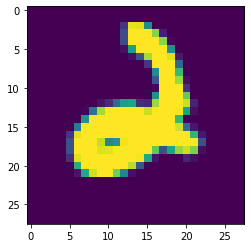

3


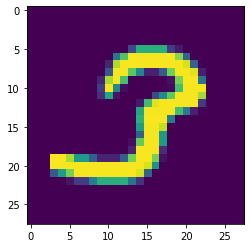

0


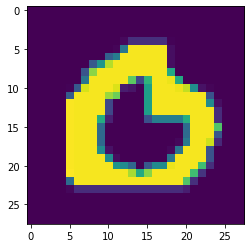

8


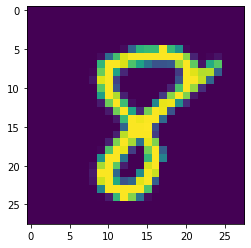

1


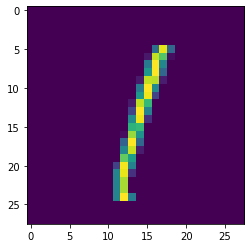

In [23]:
# Explore data
show5(training_pre_normalization_loader)

8


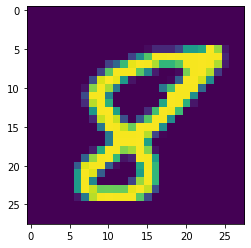

4


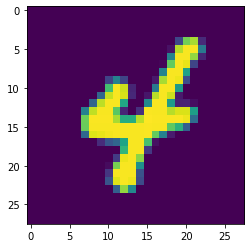

9


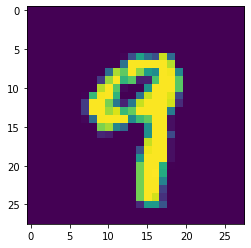

5


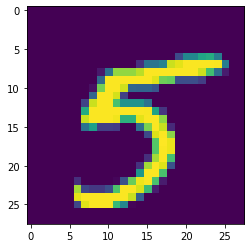

4


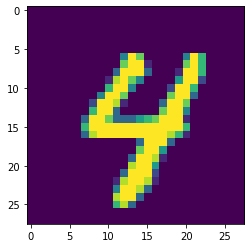

In [24]:
# Explore data
show5(training_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [25]:
class MNISTNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.layer1 = nn.Linear(28 * 28, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        
        return (x)
    
net = MNISTNNetwork()
# pass model to GPU if available
net.to(device)

MNISTNNetwork(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [26]:
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

Not using LogSoftmax as an output activation function, since nn.CrossEntropyLoss is used as loss function. Documentation of nn.CrossEntropyLoss states that it is equivalent to LogSoftmax. nn.CrossEntropyLoss is used for multi-class classification problems. It aims to minimize loss which is the different between predicted probability class and true class.

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [27]:
def trainNN(model, data_loader, device, optimizer, criterion):
    model.train()
    train_correct = 0
    train_loss = 0
    data_size = 0
    
    for i, data in enumerate(data_loader):
        inputs, labels = data
        # pass data to GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # calculate gradient of loss
        loss.backward()
        # update step
        optimizer.step()
        
        # get accuracy & loss
        values, indices = torch.max(outputs.data, 1)
        train_correct += (indices == labels).sum().item()
        train_loss += loss.item()
        data_size += len(inputs)
    
    return train_correct/data_size, train_loss/data_size

In [28]:
def evaluateNN(model, data_loader, criterion):
    model.eval()
    val_correct = 0
    val_loss = 0
    data_size = 0
    
    for i, data in enumerate(data_loader):
        inputs, labels = data
        # pass data to GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # get accuracy & loss
        values, indices = torch.max(outputs.data, 1)
        val_correct += (indices == labels).sum().item()
        val_loss += loss.item()
        data_size += len(inputs)
        
    return val_correct/data_size, val_loss/data_size

In [29]:
num_epochs = 10
train_loss_history = list()
train_accuracy_history = list()
val_accuracy_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    train_correct, train_loss = trainNN(net, training_loader, device, optimizer, criterion)
    train_accuracy_history.append(train_correct)
    train_loss_history.append(train_loss)
    
    val_correct, val_loss = evaluateNN(net, validation_loader, criterion)
    val_accuracy_history.append(val_correct)
    val_loss_history.append(val_loss)
    
    print(f'Epoch {epoch + 1} training accuracy: {train_correct*100:.2f}%, validation accuracy: {val_correct*100:.2f}%, \
    training loss: {train_loss:.5f}, validation loss: {val_loss:.5f}.')

Epoch 1 training accuracy: 90.30%, validation accuracy: 93.27%,     training loss: 0.01060, validation loss: 0.00844.
Epoch 2 training accuracy: 93.60%, validation accuracy: 92.66%,     training loss: 0.00774, validation loss: 0.00993.
Epoch 3 training accuracy: 94.27%, validation accuracy: 94.57%,     training loss: 0.00687, validation loss: 0.00715.
Epoch 4 training accuracy: 95.11%, validation accuracy: 95.23%,     training loss: 0.00622, validation loss: 0.00735.
Epoch 5 training accuracy: 95.06%, validation accuracy: 94.67%,     training loss: 0.00631, validation loss: 0.00750.
Epoch 6 training accuracy: 95.51%, validation accuracy: 95.10%,     training loss: 0.00596, validation loss: 0.00692.
Epoch 7 training accuracy: 95.67%, validation accuracy: 95.22%,     training loss: 0.00566, validation loss: 0.00781.
Epoch 8 training accuracy: 96.02%, validation accuracy: 95.32%,     training loss: 0.00533, validation loss: 0.00708.
Epoch 9 training accuracy: 96.00%, validation accuracy: 

Plot the training loss (and validation loss/accuracy, if recorded).

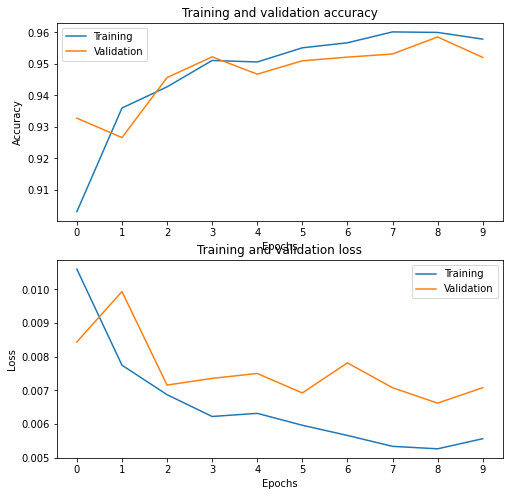

In [30]:
def pltResults(train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history):
    epochs_range = range(num_epochs)
    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, train_accuracy_history, label = 'Training')
    plt.plot(epochs_range, val_accuracy_history, label = 'Validation')
    plt.xticks(epochs_range)
    plt.legend()
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    print('\n\n\n\n')

    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, train_loss_history, label = 'Training')
    plt.plot(epochs_range, val_loss_history, label = 'Validation')
    plt.xticks(epochs_range)
    plt.legend()
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    return (plt)

plt = pltResults(train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history)
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [31]:
val_correct, val_loss = evaluateNN(net, testing_loader, criterion)
print(f'Testing accuracy: {val_correct*100:.2f}%')

Testing accuracy: 94.84%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [32]:
## YOUR CODE HERE ##
class MNISTNNetworkImrpoved(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.layer1 = nn.Linear(28 * 28, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 10)
        self.dropoutLayer = nn.Dropout(p=0.25)
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.layer1(x))
        x = self.dropoutLayer(x)
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        
        return (x)
    
improve_net = MNISTNNetworkImrpoved()
# pass model to GPU if available
improve_net.to(device)

MNISTNNetworkImrpoved(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=10, bias=True)
  (dropoutLayer): Dropout(p=0.25, inplace=False)
)

In [33]:
optimizer = optim.SGD(improve_net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_loss_history = list()
train_accuracy_history = list()
val_accuracy_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    train_correct, train_loss = trainNN(improve_net, training_loader, device, optimizer, criterion)
    train_accuracy_history.append(train_correct)
    train_loss_history.append(train_loss)
    
    val_correct, val_loss = evaluateNN(improve_net, validation_loader, criterion)
    val_accuracy_history.append(val_correct)
    val_loss_history.append(val_loss)
    
    print(f'Epoch {epoch + 1} training accuracy: {train_correct*100:.2f}%, validation accuracy: {val_correct*100:.2f}%, \
    training loss: {train_loss:.5f}, validation loss: {val_loss:.5f}.')

Epoch 1 training accuracy: 78.94%, validation accuracy: 90.68%,     training loss: 0.02330, validation loss: 0.00992.
Epoch 2 training accuracy: 91.01%, validation accuracy: 93.05%,     training loss: 0.00953, validation loss: 0.00725.
Epoch 3 training accuracy: 93.15%, validation accuracy: 94.41%,     training loss: 0.00735, validation loss: 0.00587.
Epoch 4 training accuracy: 94.22%, validation accuracy: 95.09%,     training loss: 0.00613, validation loss: 0.00508.
Epoch 5 training accuracy: 95.07%, validation accuracy: 95.70%,     training loss: 0.00524, validation loss: 0.00449.
Epoch 6 training accuracy: 95.60%, validation accuracy: 95.95%,     training loss: 0.00468, validation loss: 0.00406.
Epoch 7 training accuracy: 95.92%, validation accuracy: 96.31%,     training loss: 0.00425, validation loss: 0.00380.
Epoch 8 training accuracy: 96.32%, validation accuracy: 96.48%,     training loss: 0.00392, validation loss: 0.00359.
Epoch 9 training accuracy: 96.59%, validation accuracy: 

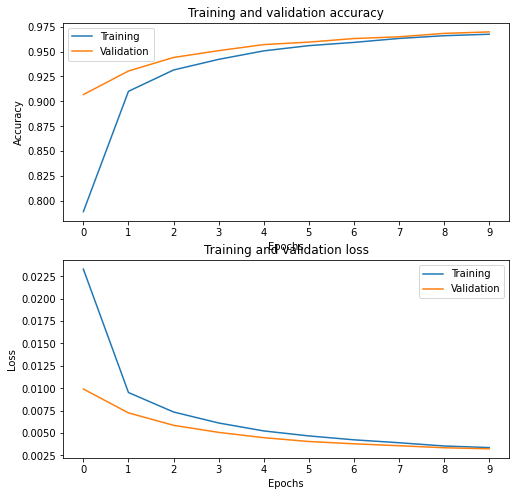

In [34]:
plt = pltResults(train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history)
plt.show()

In [35]:
test_correct, test_loss = evaluateNN(improve_net, testing_loader, criterion)
print(f'Testing accuracy: {test_correct*100:.2f}%')

Testing accuracy: 97.08%


## Saving your model
Using `torch.save`, save your model for future loading.

In [36]:
# Save the model
torch.save(improve_net.state_dict(), 'model.pth')

In [37]:
torch.load('model.pth')

OrderedDict([('layer1.weight',
              tensor([[ 0.0288,  0.0168,  0.0019,  ...,  0.0141, -0.0127,  0.0360],
                      [ 0.0090,  0.0247,  0.0142,  ..., -0.0290,  0.0252,  0.0348],
                      [ 0.0257,  0.0189,  0.0184,  ...,  0.0032, -0.0046,  0.0233],
                      ...,
                      [-0.0043, -0.0123, -0.0040,  ..., -0.0209, -0.0149, -0.0221],
                      [ 0.0252, -0.0064,  0.0354,  ...,  0.0218,  0.0206, -0.0336],
                      [ 0.0312,  0.0220, -0.0098,  ..., -0.0009, -0.0014, -0.0119]])),
             ('layer1.bias',
              tensor([-0.0310,  0.0096, -0.0215, -0.0122, -0.0034, -0.0010, -0.0130,  0.0108,
                       0.0214, -0.0241, -0.0343,  0.0205,  0.0181,  0.0113, -0.0235, -0.0116,
                       0.0019, -0.0128,  0.0091, -0.0007, -0.0177, -0.0261, -0.0163, -0.0229,
                      -0.0082, -0.0158, -0.0285,  0.0193,  0.0085, -0.0251,  0.0239,  0.0132,
                       0.0065,